In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import joblib

import Models
from AuxiliarFunctions import *

2023-03-26 23:13:52.299138: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Carga de Dados

In [2]:
config_file_path = 'data/config.csv'
df_config = pd.read_csv(config_file_path)
train_id = 0

In [3]:
df_config

hash_id                                             label  \
0  6111500007297378247  Toy Data Classification with 10 StratifiedKFolds   

  raw_files_path processed_file_folder  \
0       data/raw                  data   

                           processed_file_path            cv_alg  cv_folds  \
0  data/6111500007297378247_processed_data.csv  StratifiedKFolds        10   

        cv_path                           preproc_alg   pipeline_path  \
0  data/indexes  Não implementado para a aplicação!!!  data/pipelines   

       scaler_alg                          train_data_path  \
0  StandardScaler  data/6111500007297378247_train_data.csv   

                          train_trgt_path   model_path  
0  data/6111500007297378247_trgt_data.csv  data/models

In [4]:
df_data = pd.read_csv(df_config['train_data_path'][train_id])
df_trgt = pd.read_csv(df_config['train_trgt_path'][train_id])

In [5]:
model_path = df_config['model_path'][train_id]
df_choose_hyperparameters = pd.read_csv(os.path.join(model_path, 'choose_hyperparameters.csv'))

In [6]:
print('Choose hyperparams - kernel %s and regularization %s'%(df_choose_hyperparameters['kernel'].values[0],
                                                              df_choose_hyperparameters['regularization'].values[0]))

Choose hyperparams - kernel rbf and regularization 0.9


# Figuras de Mérito de Classificação

In [7]:
train_record = pd.read_csv(os.path.join(model_path, 'train_record.csv'))
selected_train = train_record[(train_record['kernel']==df_choose_hyperparameters['kernel'].values[0]) & 
                              (train_record['regularization']==df_choose_hyperparameters['regularization'].values[0])]

In [ ]:
train_record = pd.read_csv(os.path.join(model_path, 'train_record.csv'))

mean_grouped = selected_train[['kernel','regularization',
                        'Acc','Sens','Spec','SP', 'AUC', 'Time']].groupby(['kernel', 'regularization']).mean()
std_grouped = selected_train[['kernel','regularization',
                        'Acc','Sens','Spec','SP', 'AUC', 'Time']].groupby(['kernel', 'regularization']).std()
grouped = pd.concat([mean_grouped,std_grouped],axis=0)

grouped

# Matriz de Confusão

Processing SVM Analysis
Processing Analysis for rbf kernel
Processing Analysis for 0.9 regularization
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_0_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_1_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_2_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 4 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_3_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 5 fold of 10 folds

Reading Cross-validation ind

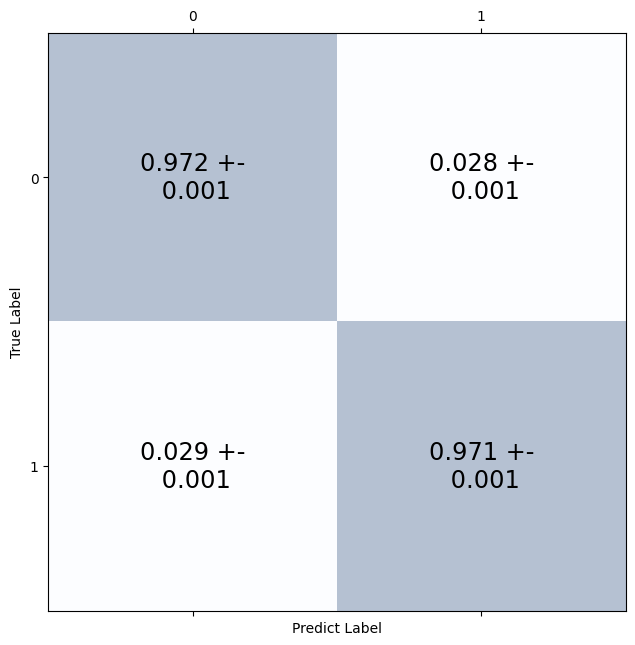

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'SVM'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing SVM Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
regularizations = [df_choose_hyperparameters['regularization'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for regularization in regularizations:
        print('Processing Analysis for %s regularization'%(regularization))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_regularization.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                str(regularization).replace('.','-'))
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                (tn, fp, fn, tp) = Models.get_confusion_matrix(df_predict.loc[trn_idx,'target'],
                                                               df_predict.loc[trn_idx,'model_output'])
                #print((tn, fp, fn, tp))
                conf_mat[0,0,ifold] = tn
                conf_mat[0,1,ifold] = fp
                conf_mat[1,0,ifold] = fn
                conf_mat[1,1,ifold] = tp
            else:
                print('No Model \n')

# ============================================== #
#                      Drawing                   #
# ============================================== #
fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix_mean = np.mean(conf_mat,axis=2)
conf_matrix_std = np.std(conf_mat,axis=2)

ax.matshow(conf_matrix_mean, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix_mean.shape[0]):
    for j in range(conf_matrix_mean.shape[1]):
        text = '%1.3f +-\n %1.3f'%(conf_matrix_mean[i, j],conf_matrix_std[i, j])
        ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')
ax.set_xticks([0,1])
ax.set_title('Classification for training set')

Processing SVM Analysis
Processing Analysis for rbf kernel
Processing Analysis for 0.9 regularization
Analysing 1 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_0_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 2 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_1_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 3 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_2_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 4 fold of 10 folds

Reading Cross-validation indexes
Done
Reading Pipeline Object
Done
Loading for model
Model is in data/models/6111500007297378247_SVM_3_fold_model_rbf_kernel_0-9_regularization.pkl
Analysing 5 fold of 10 folds

Reading Cross-validation ind

Text(0.5, 1.0, 'Classification for validation set')

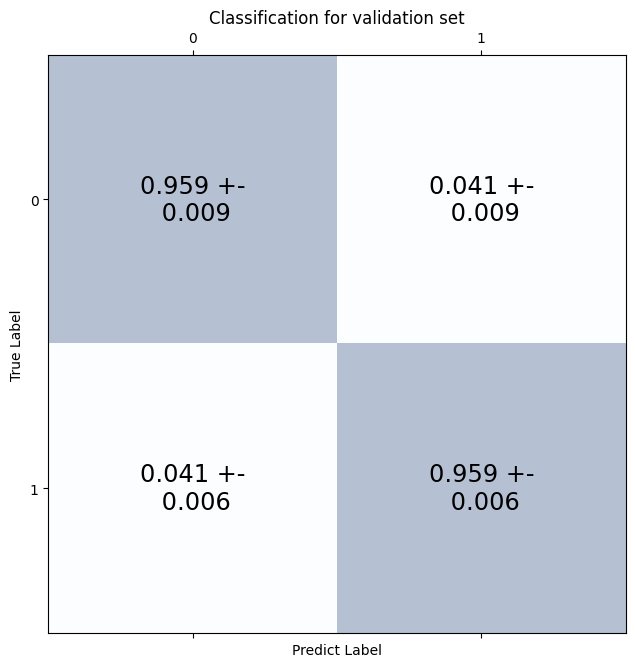

In [39]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import time

import copy

model_type = 'SVM'
n_folds =  df_config['cv_folds'][train_id]

cv_path = df_config['cv_path'][train_id]
pipe_path = df_config['pipeline_path'][train_id]
model_path = df_config['model_path'][train_id]

print('Processing SVM Analysis')

kernels = [df_choose_hyperparameters['kernel'].values[0]]
regularizations = [df_choose_hyperparameters['regularization'].values[0]]


conf_mat = np.zeros((2,2,n_folds))

for kernel in kernels:
    print('Processing Analysis for %s kernel'%(kernel))
    for regularization in regularizations:
        print('Processing Analysis for %s regularization'%(regularization))
        for ifold in range(n_folds):
            #if ifold >= 2: # para desenvolvimento
            #    break
            print('Analysing %i fold of %i folds\n'%(ifold+1, n_folds))
            print('Reading Cross-validation indexes')

            cv_name = '%s_%s_CV_fold_%i_of_%i_cv_indexes.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            print('Done')
            print('Reading Pipeline Object')
            with open(os.path.join(cv_path,cv_name),'rb') as file_handler:
                [trn_idx,val_idx] = pickle.load(file_handler)

            pipe_name ='%s_%s_CV_fold_%i_of_%i_pipe.pkl'%(df_config['hash_id'][train_id],
                                                               df_config['cv_alg'][train_id],
                                                               ifold, n_folds)
            with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
                pipe = joblib.load(file_handler)

            print('Done')

            trn_data = pipe.transform(df_data)
            trn_trgt = df_trgt.values # tf.keras.utils.to_categorical(dev_target, num_classes=len(np.unique(dev_target)))

            print('Loading for model')
            model_name = '%s_%s_%i_fold_model_%s_kernel_%s_regularization.pkl'%(df_config['hash_id'][train_id],
                                                                                model_type, ifold, kernel, 
                                                                                str(regularization).replace('.','-'))
            if os.path.exists(os.path.join(model_path, model_name)):
                print('Model is in %s'%(os.path.join(model_path, model_name)))
                prediction_name = copy.copy(model_name)
                prediction_name = prediction_name.replace('.pkl','_prediction_file.csv')
                df_predict = pd.read_csv(os.path.join(model_path, prediction_name))
                (tn, fp, fn, tp) = Models.get_confusion_matrix(df_predict.loc[val_idx,'target'],
                                                               df_predict.loc[val_idx,'model_output'])
                #print((tn, fp, fn, tp))
                conf_mat[0,0,ifold] = tn
                conf_mat[0,1,ifold] = fp
                conf_mat[1,0,ifold] = fn
                conf_mat[1,1,ifold] = tp
            else:
                print('No Model \n')

# ============================================== #
#                      Drawing                   #
# ============================================== #
fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix_mean = np.mean(conf_mat,axis=2)
conf_matrix_std = np.std(conf_mat,axis=2)

ax.matshow(conf_matrix_mean, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix_mean.shape[0]):
    for j in range(conf_matrix_mean.shape[1]):
        text = '%1.3f +-\n %1.3f'%(conf_matrix_mean[i, j],conf_matrix_std[i, j])
        ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
ax.set_xlabel('Predict Label')
ax.set_ylabel('True Label')
ax.set_xticks([0,1])
ax.set_title('Classification for validation set')

# Análise de Relevância

In [15]:
# for kFolds CV

from sklearn.metrics import accuracy_score
from AuxiliarFunctions import *
import Models
import joblib

print(get_train_description(df_config, train_id))

print('Analysis Starting')

datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']

ineuron = [2,2,3,2]
iinit = 0

pipe_path = df_config['pipeline_path'][train_id]

#figure_of_merit_relevance_refence = np.zeros((len(datasets_data),n_folds,1))
#figure_of_merit_relevance_matrix = np.zeros((len(datasets_data),n_folds,data.shape[1]))

figure_of_merit_relevance_refence = {}
figure_of_merit_relevance_matrix = {}
for idataset, dataset_name in enumerate(datasets_name): 
    # data
    model_type = 'MLPNeuralNetwork'
    data = datasets_data[idataset]
    print('Data shape: (%i, %i)'%(data.shape[0], data.shape[1]))

    trgt = dev_target.values
    print('Trgt shape: %i'%(trgt.shape[0]))

    hidden_neurons = list(get_list_of_hidden_neurons(df_config['model_neurons'][train_id]))

    with open(df_config['model_status'][train_id],'rb') as file_handler:
        [model_status] = pickle.load(file_handler)


    n_folds = df_config['cv_folds'][train_id]
    model_hidden_neurons = 100 
    
    model_relevance_matrix = np.zeros((data.shape[1]+1, n_folds))
    relevance = np.zeros((data.shape[1], n_folds))
    relative_relevance = np.zeros((data.shape[1], n_folds))
    
    #figure_of_merit_relevance_refence[idataset] = np.zeros((n_folds,1))
    #figure_of_merit_relevance_matrix[idataset] = np.zeros((n_folds,data.shape[1]))

    for ifold in range(n_folds):
        print('Analysing %i fold of %i folds'%(ifold+1, n_folds))
        # pipeline
        pipe_name = '%s_%s_CV_fold_%i_of_%i_pipe_%s.jbl'%(df_config['hash_id'][train_id],
                                                          df_config['cv_alg'][train_id],
                                                          ifold, n_folds, 
                                                          datasets_name[idataset])
        with open(os.path.join(pipe_path,pipe_name),'rb') as file_handler:
            pipe = joblib.load(file_handler)

        trn_data = pipe.transform(data)
        trn_trgt = tf.keras.utils.to_categorical(trgt, num_classes=len(np.unique(trgt)))


        print('Analysing for %i neurons'%(model_hidden_neurons))

        model_name = '%s_%s_%i_fold_%i_neuron_%i_init_model_%s.pkl'%(df_config['hash_id'][train_id],
                                                                             model_type,ifold, 
                                                                             ineuron[idataset],iinit,
                                                                             datasets_name[idataset])
        model_path = df_config['model_path'][train_id]    
        
        if not os.path.exists(os.path.join(model_path, model_name)):    
            print('Modelo não existe\n')
            continue

        else:
            print('Modelo existente em %s'%(os.path.join(model_path, model_name)))
            model = Models.MLPModel(n_hidden_neurons=ineuron,verbose=2)
            model.load(os.path.join(model_path, model_name))
            predictions = model.predict(trn_data)
            predictions = np.sign(predictions)
            ref_value = accuracy_score(trgt,predictions)
            model_relevance_matrix[0,ifold] = ref_value
            #figure_of_merit_relevance_refence[idataset][ifold] = value
            print('Value of Figure of Merit (Acc): ',ref_value)

            for iinput in range(data.shape[1]):
                print('Analysing for %i input in'%(iinput),data.shape[1])
                buffer_data = np.copy(trn_data)
                buffer_data[:,iinput] = np.mean(buffer_data[:,iinput])
                predictions = model.predict(buffer_data)
                predictions = np.sign(predictions)
                value = Models.acc_score(trgt,predictions)
                model_relevance_matrix[iinput+1,ifold] = value
                print('Value of Figure of Merit (Acc): ',value)
                relevance[iinput,ifold] = ref_value - value
                relative_relevance[iinput,ifold] = (ref_value - value)/ref_value
    df_model_relevance_matrix = pd.DataFrame(data=model_relevance_matrix, columns=range(n_folds), 
                                             index=['All inputs'] + list(data.columns))
    df_model_relevance_matrix.to_csv(os.path.join(model_path, '%s_relevance_anal_mat.csv'%(dataset_name)))
    df_relevance = pd.DataFrame(data=relevance, 
                                columns=range(n_folds),
                                index=list(data.columns))
    df_relevance.to_csv(os.path.join(model_path, '%s_relevance_anal.csv'%(dataset_name)))
    df_relative_relevance = pd.DataFrame(data=relative_relevance, 
                                columns=range(n_folds),
                                index=list(data.columns))
    df_relative_relevance.to_csv(os.path.join(model_path, '%s_relative_relevance_anal.csv'%(dataset_name)))




TB Data Classification with StratifiedKFolds Training Process
Processing data/8691172013082741024_train_data.csv
Hidden Neurons: 2, 3, 4, 5
CV Folds: 5
Inits: 1

Analysis Starting
Data shape: (54, 13)
Trgt shape: 54
Analysing 1 fold of 5 folds
Analysing for 100 neurons
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_0_fold_2_neuron_0_init_model_social.pkl
2/2 [==============================] - 0s 5ms/step
Value of Figure of Merit (Acc):  0.7407407407407407
Analysing for 0 input in 13
2/2 [==============================] - 0s 6ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 13
2/2 [==============================] - 0s 4ms/step
Value of Figure of Merit (Acc):  0.7407407407407407
Analysing for 2 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7407407407407407
Analysing for 3 input in 13
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.75925925

2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 0 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 2 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 3 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 4 input in 13
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.6481481481481481
Analysing for 5 input in 13
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 6 input in 13
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc): 

2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 4
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.6296296296296297
Analysing for 2 input in 4
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 3 input in 4
2/2 [==============================] - 0s 2ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing 5 fold of 5 folds
Analysing for 100 neurons
Modelo existente em data/models/8691172013082741024_MLPNeuralNetwork_4_fold_3_neuron_0_init_model_pos_test.pkl
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7962962962962963
Analysing for 0 input in 4
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):  0.7222222222222222
Analysing for 1 input in 4
2/2 [==============================] - 0s 3ms/step
Value of Figure of Merit (Acc):

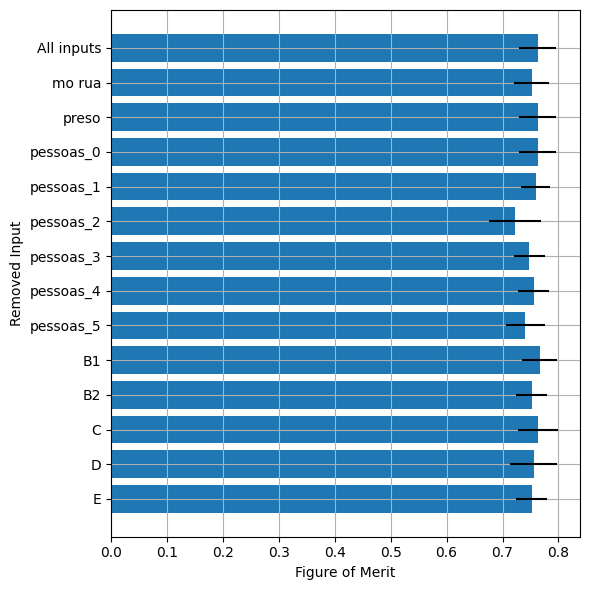

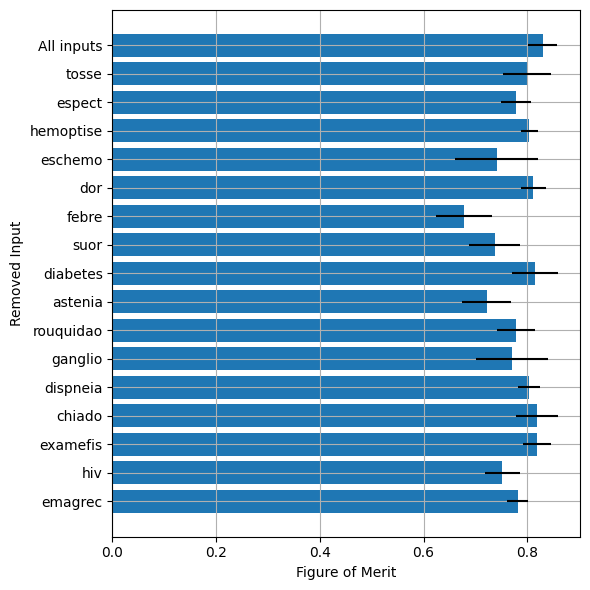

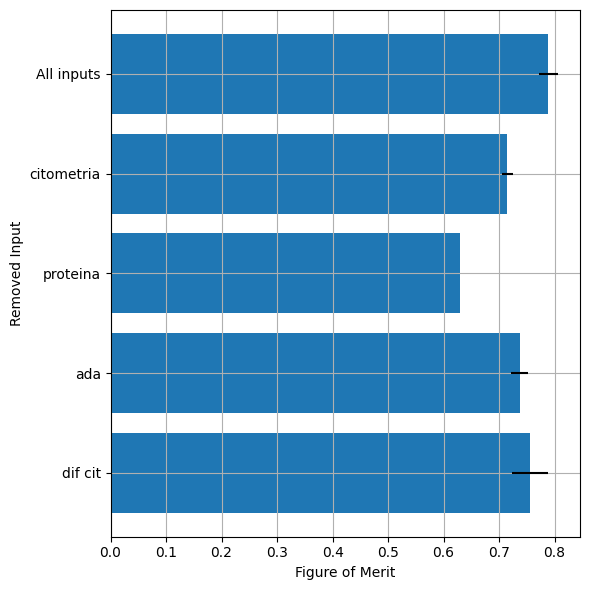

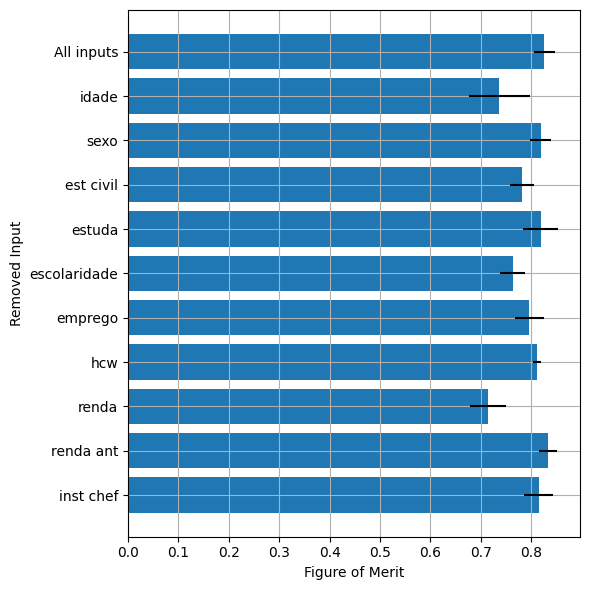

In [16]:
import matplotlib.pyplot as plt


datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']


for idataset, dataset_name in enumerate(datasets_name): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    data = datasets_data[idataset]
    
    df_model_relevance_matrix = pd.read_csv(os.path.join(model_path, '%s_relevance_anal_mat.csv'%(dataset_name)),index_col=0)
    
    y = np.arange(df_model_relevance_matrix.shape[0])
    x = df_model_relevance_matrix.mean(axis=1).values
    x_err = df_model_relevance_matrix.std(axis=1).values
    
    ax.barh(y, x, xerr=x_err, align='center')
    
    ax.set_yticks(y, labels=df_model_relevance_matrix.index.values)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Figure of Merit')
    ax.set_ylabel('Removed Input')
    plt.tight_layout()
    
    plt.grid()
    plt.show()

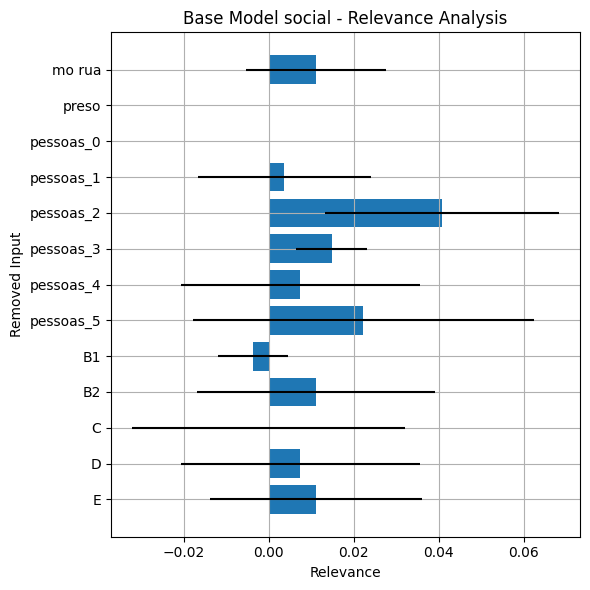

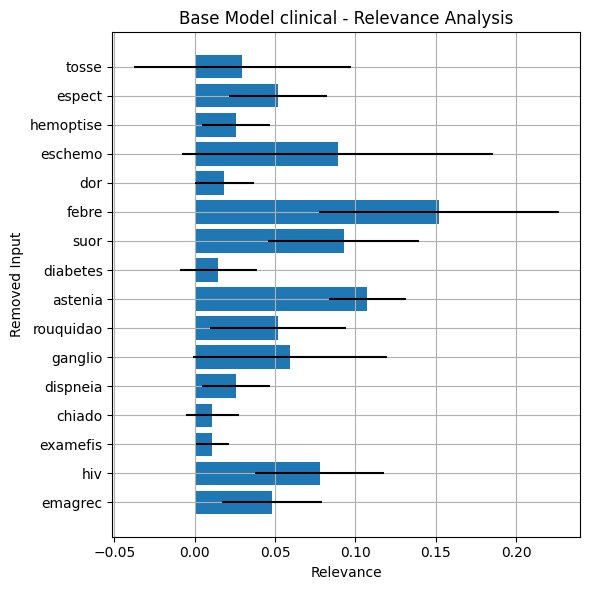

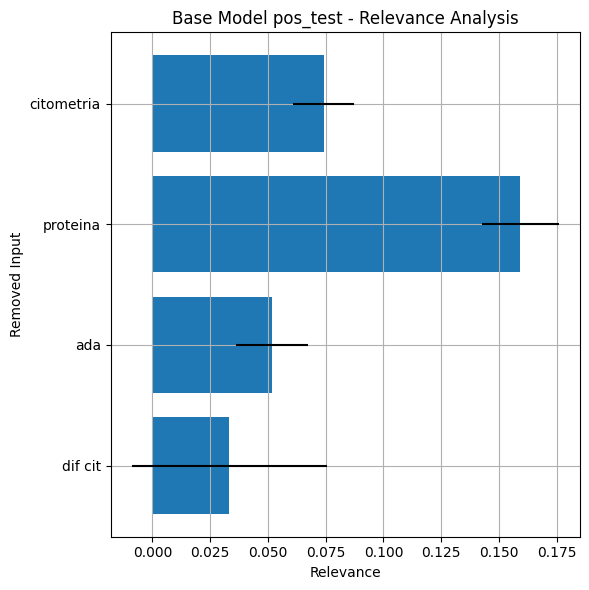

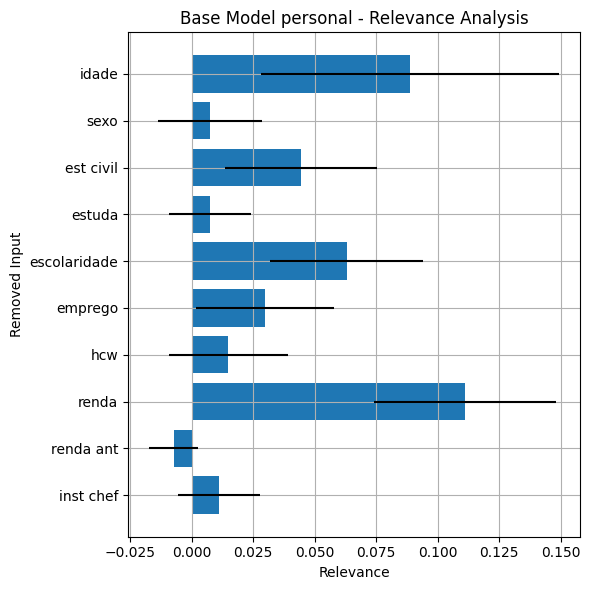

In [17]:
import matplotlib.pyplot as plt


datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']


for idataset, dataset_name in enumerate(datasets_name): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    data = datasets_data[idataset]
    
    df_model_relevance_matrix = pd.read_csv(os.path.join(model_path, '%s_relevance_anal.csv'%(dataset_name)),index_col=0)
    
    y = np.arange(df_model_relevance_matrix.shape[0])
    x = df_model_relevance_matrix.mean(axis=1).values
    x_err = df_model_relevance_matrix.std(axis=1).values
    
    ax.barh(y, x, xerr=x_err, align='center')
    
    ax.set_yticks(y, labels=df_model_relevance_matrix.index.values)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Relevance')
    ax.set_ylabel('Removed Input')
    ax.set_title('Base Model %s - Relevance Analysis'%(dataset_name))
    plt.tight_layout()
    
    plt.grid()
    plt.show()

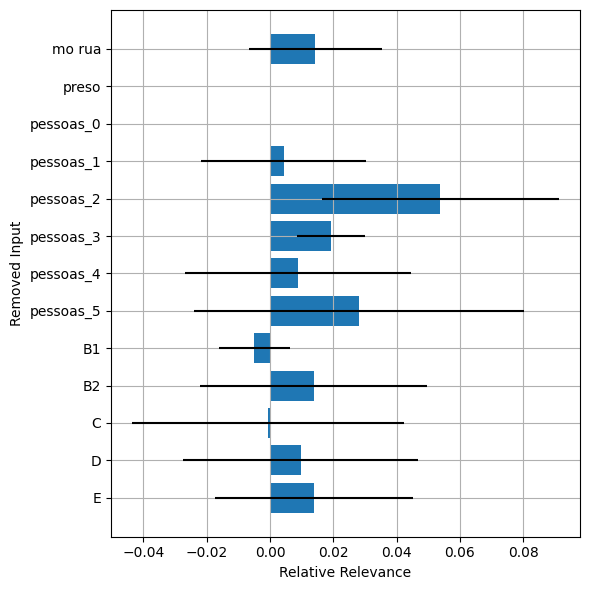

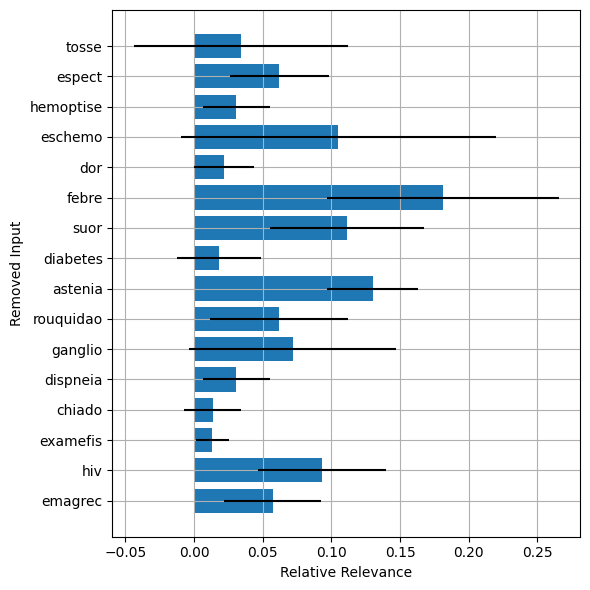

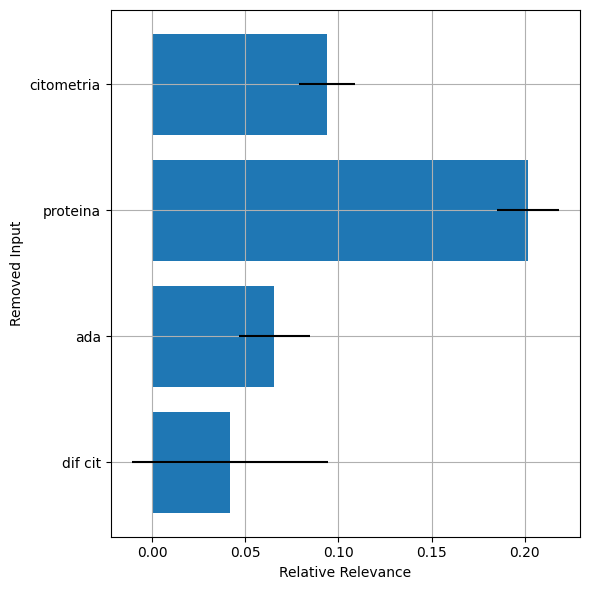

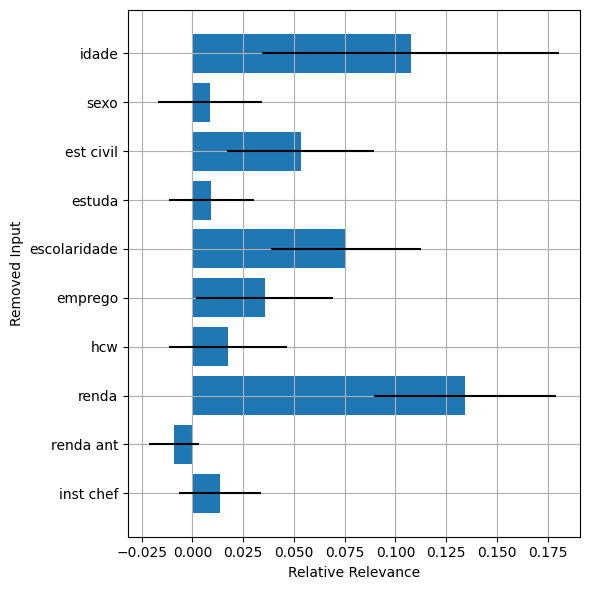

In [18]:
import matplotlib.pyplot as plt


datasets_data = [dev_social, dev_clinical, dev_pos_test, dev_personal]
datasets_name = ['social', 'clinical', 'pos_test', 'personal']


for idataset, dataset_name in enumerate(datasets_name): 
    fig, ax = plt.subplots(figsize=(6, 6)) 
    
    data = datasets_data[idataset]
    
    df_model_relevance_matrix = pd.read_csv(os.path.join(model_path, '%s_relative_relevance_anal.csv'%(dataset_name)),index_col=0)
    
    y = np.arange(df_model_relevance_matrix.shape[0])
    x = df_model_relevance_matrix.mean(axis=1).values
    x_err = df_model_relevance_matrix.std(axis=1).values
    
    ax.barh(y, x, xerr=x_err, align='center')
    
    ax.set_yticks(y, labels=df_model_relevance_matrix.index.values)
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.set_xlabel('Relative Relevance')
    ax.set_ylabel('Removed Input')
    plt.tight_layout()
    
    plt.grid()
    plt.show()

# Scatter Plots

Seixas pediu um scatter plot de todas as variáveis. Como fazer isso e como analisar?

<ipython-input-24-dee3149ebeec>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(dev_social, alpha=0.2, ax=ax)


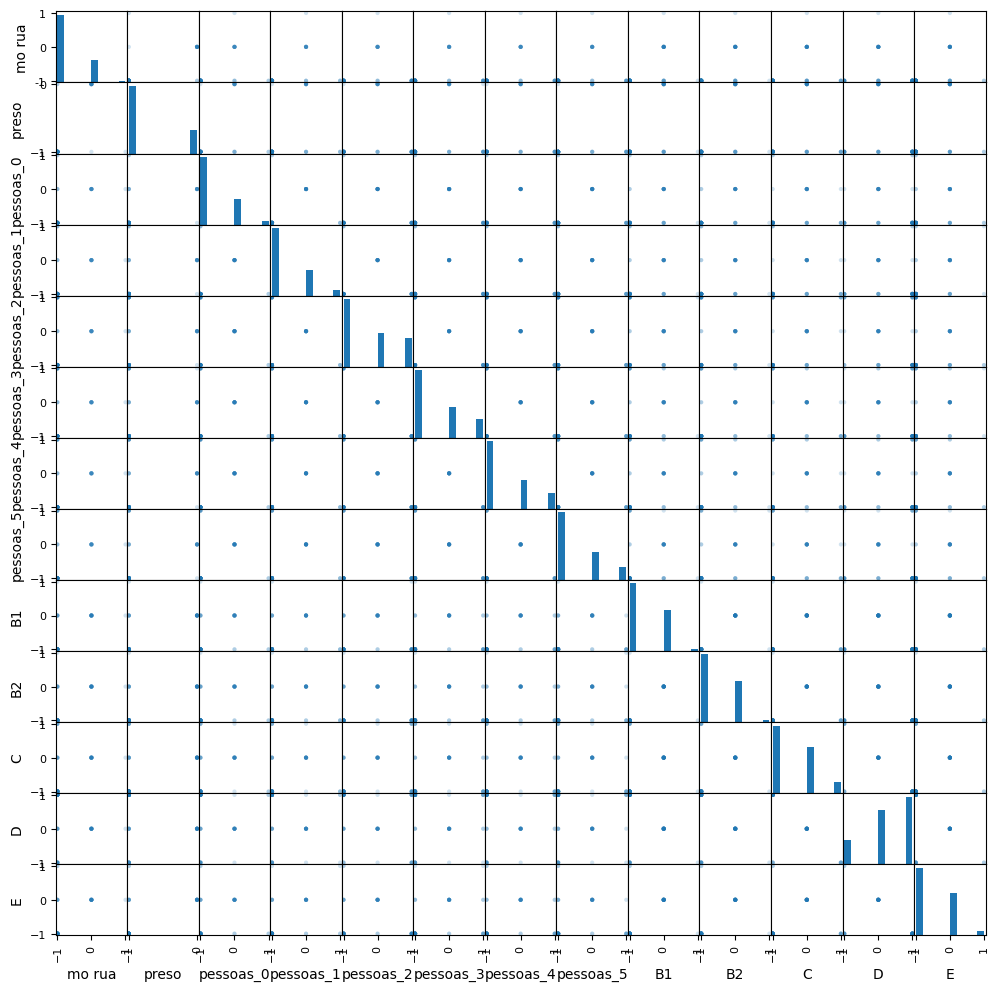

In [24]:
fig, ax = plt.subplots(figsize=(12, 12)) 
   
pd.plotting.scatter_matrix(dev_social, alpha=0.2, ax=ax)
plt.show()

<Figure size 640x480 with 0 Axes>

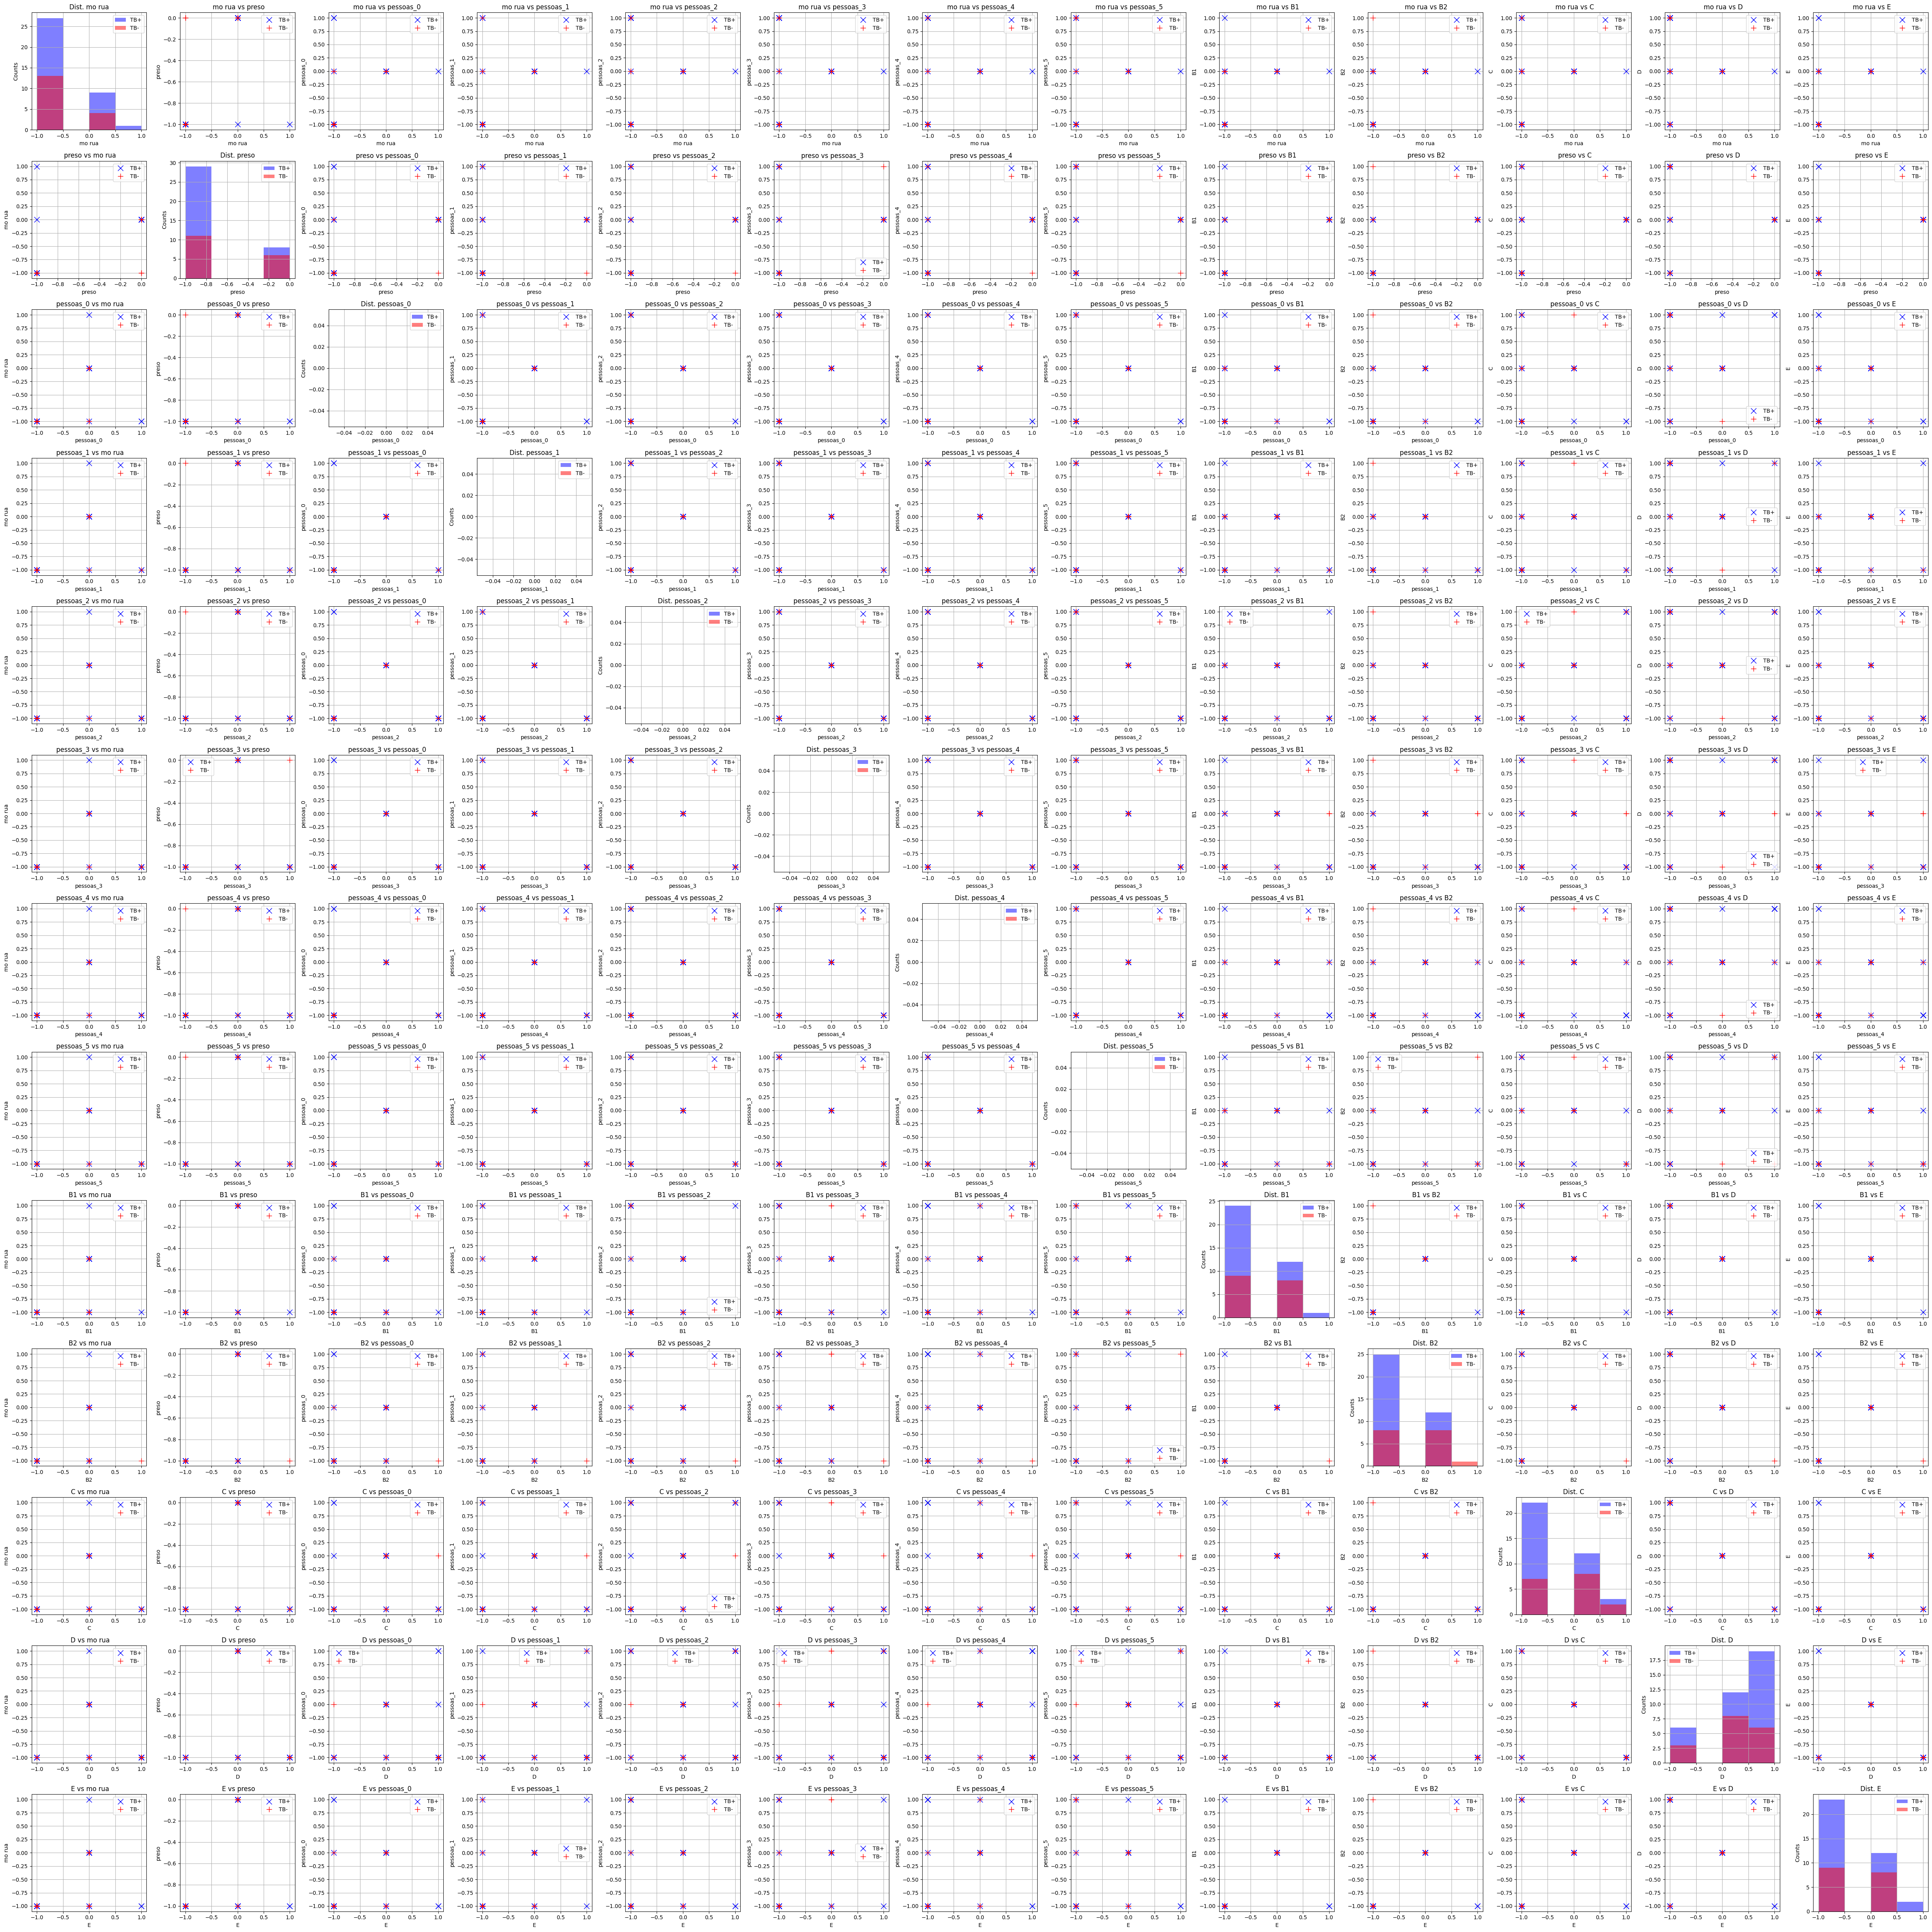

In [116]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_social
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(50, 50))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_social.pdf',bbox_inches='tight')
fig.savefig('scatter_social.png',bbox_inches='tight', dpi=400)
plt.show()


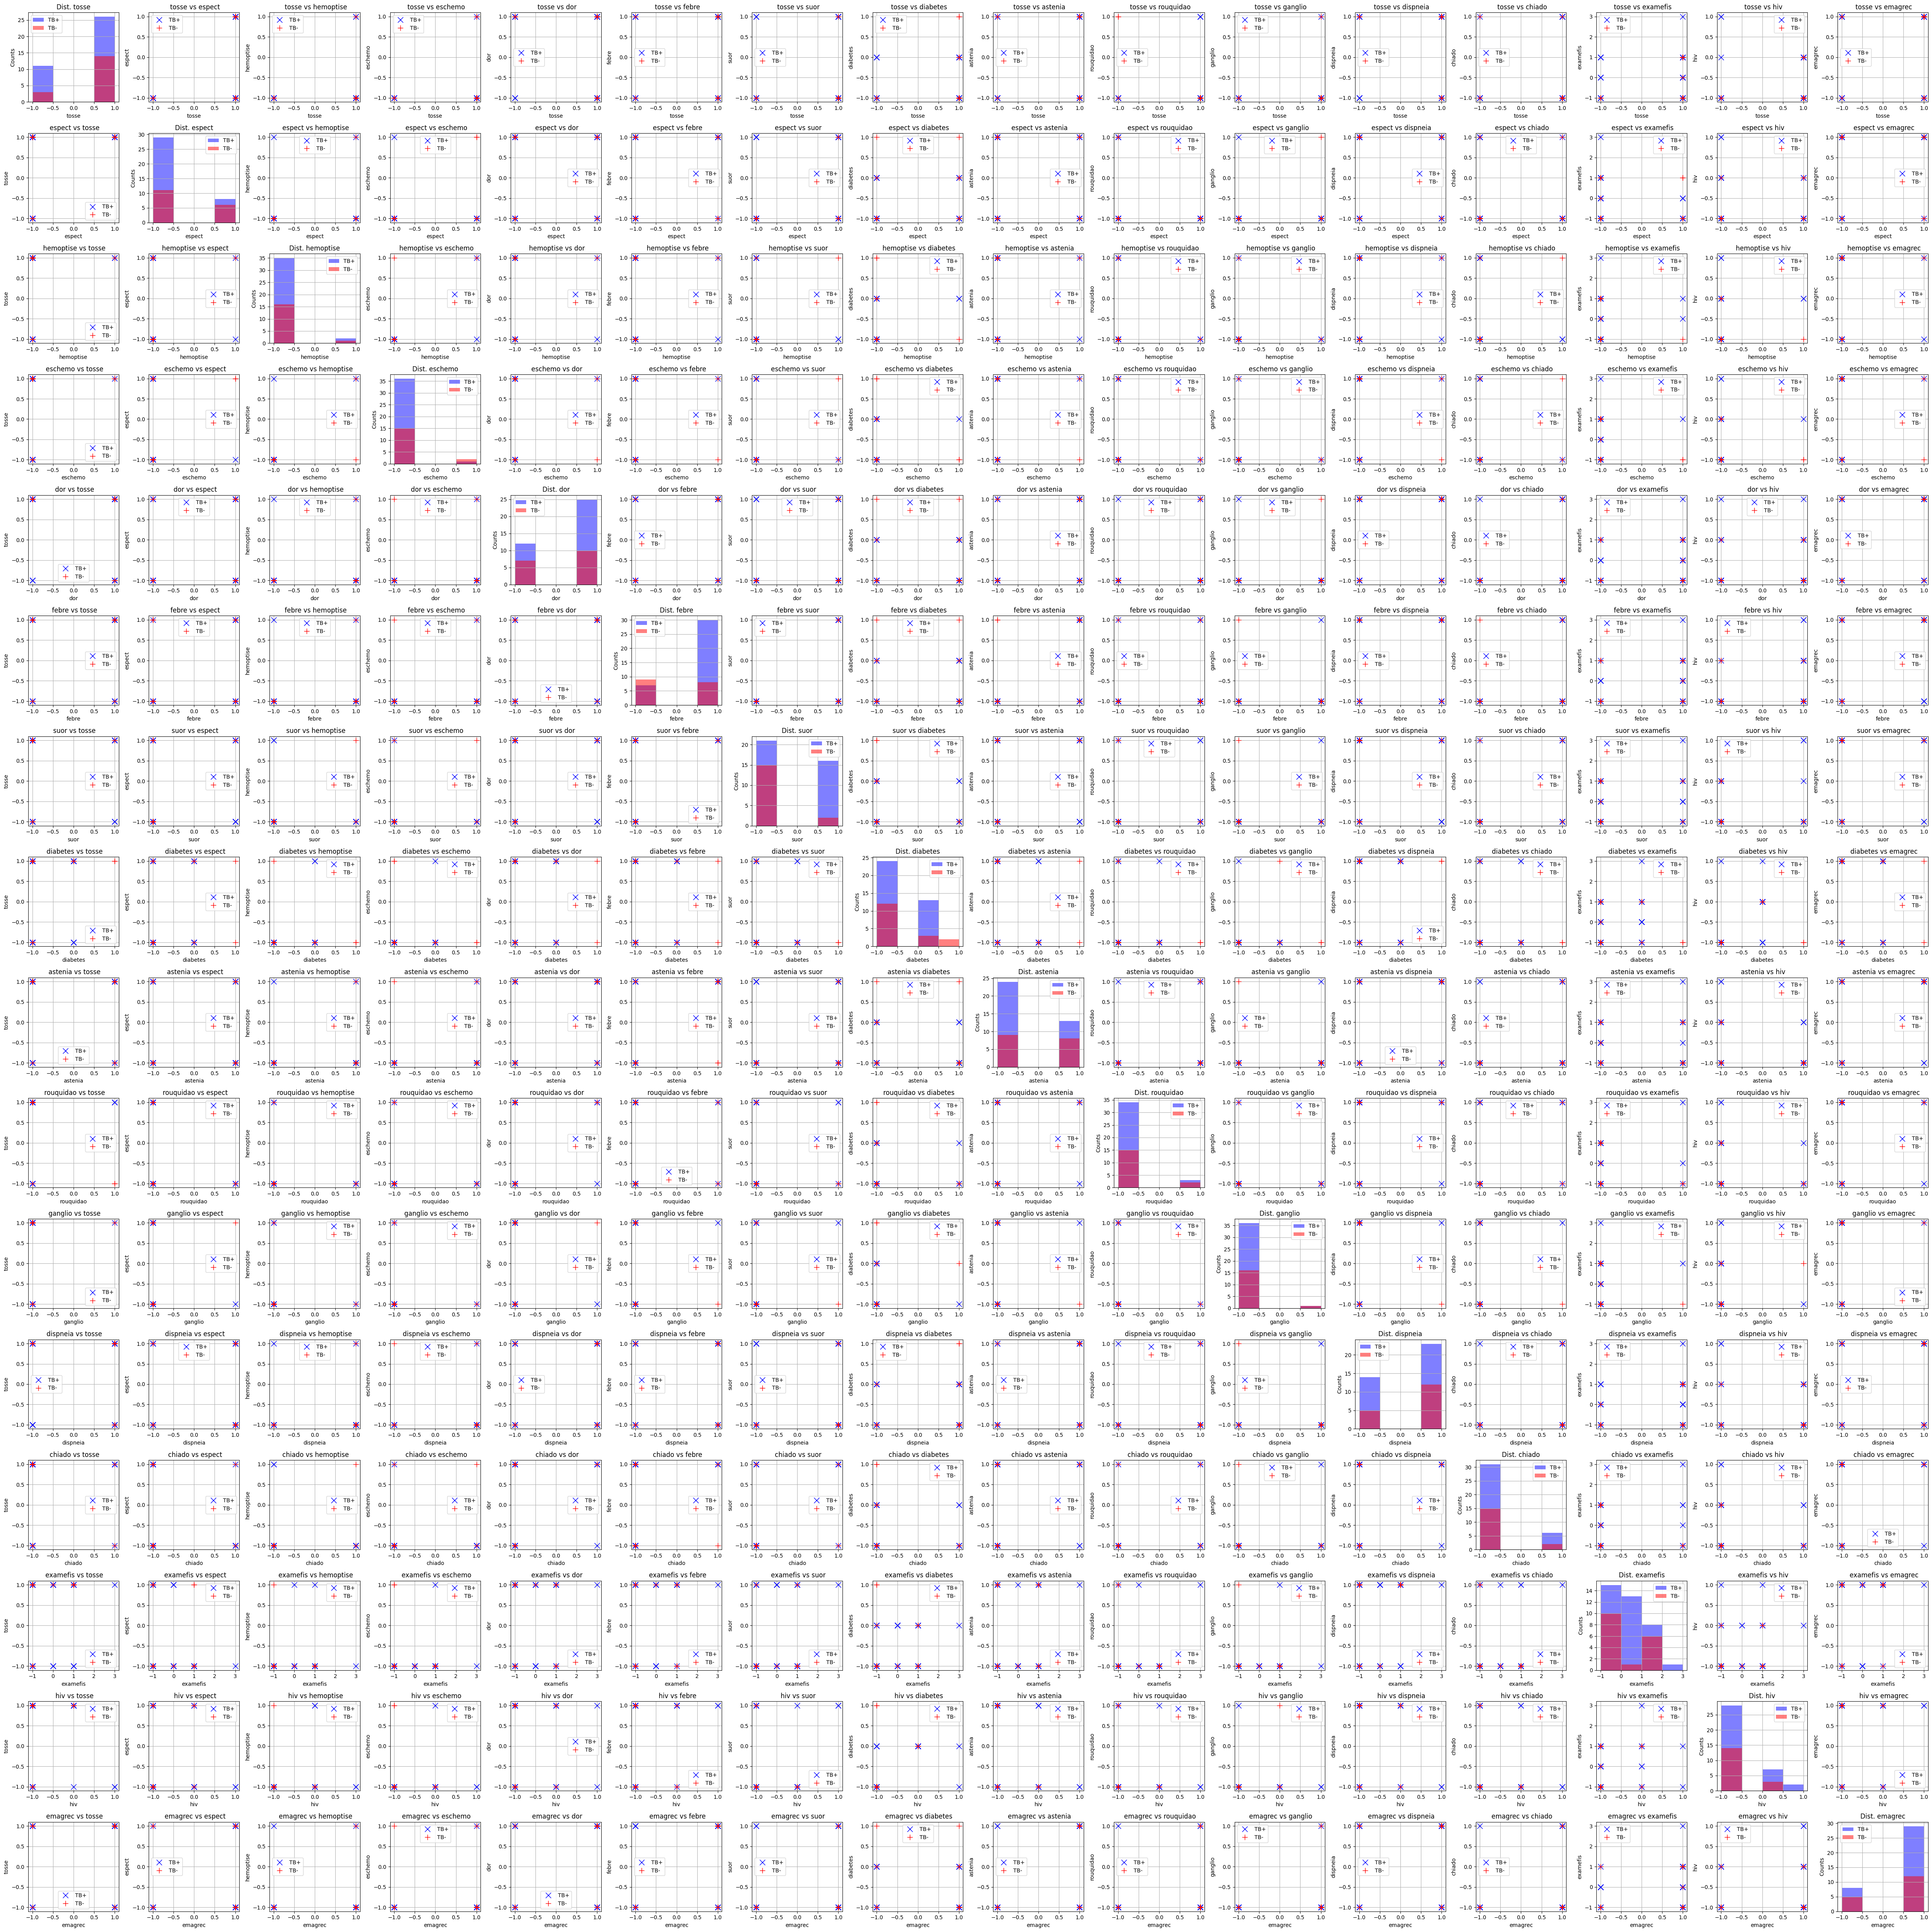

In [117]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_clinical
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(50, 50))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_clinical.pdf',bbox_inches='tight')
fig.savefig('scatter_clinical.png',bbox_inches='tight', dpi=400)
plt.show()

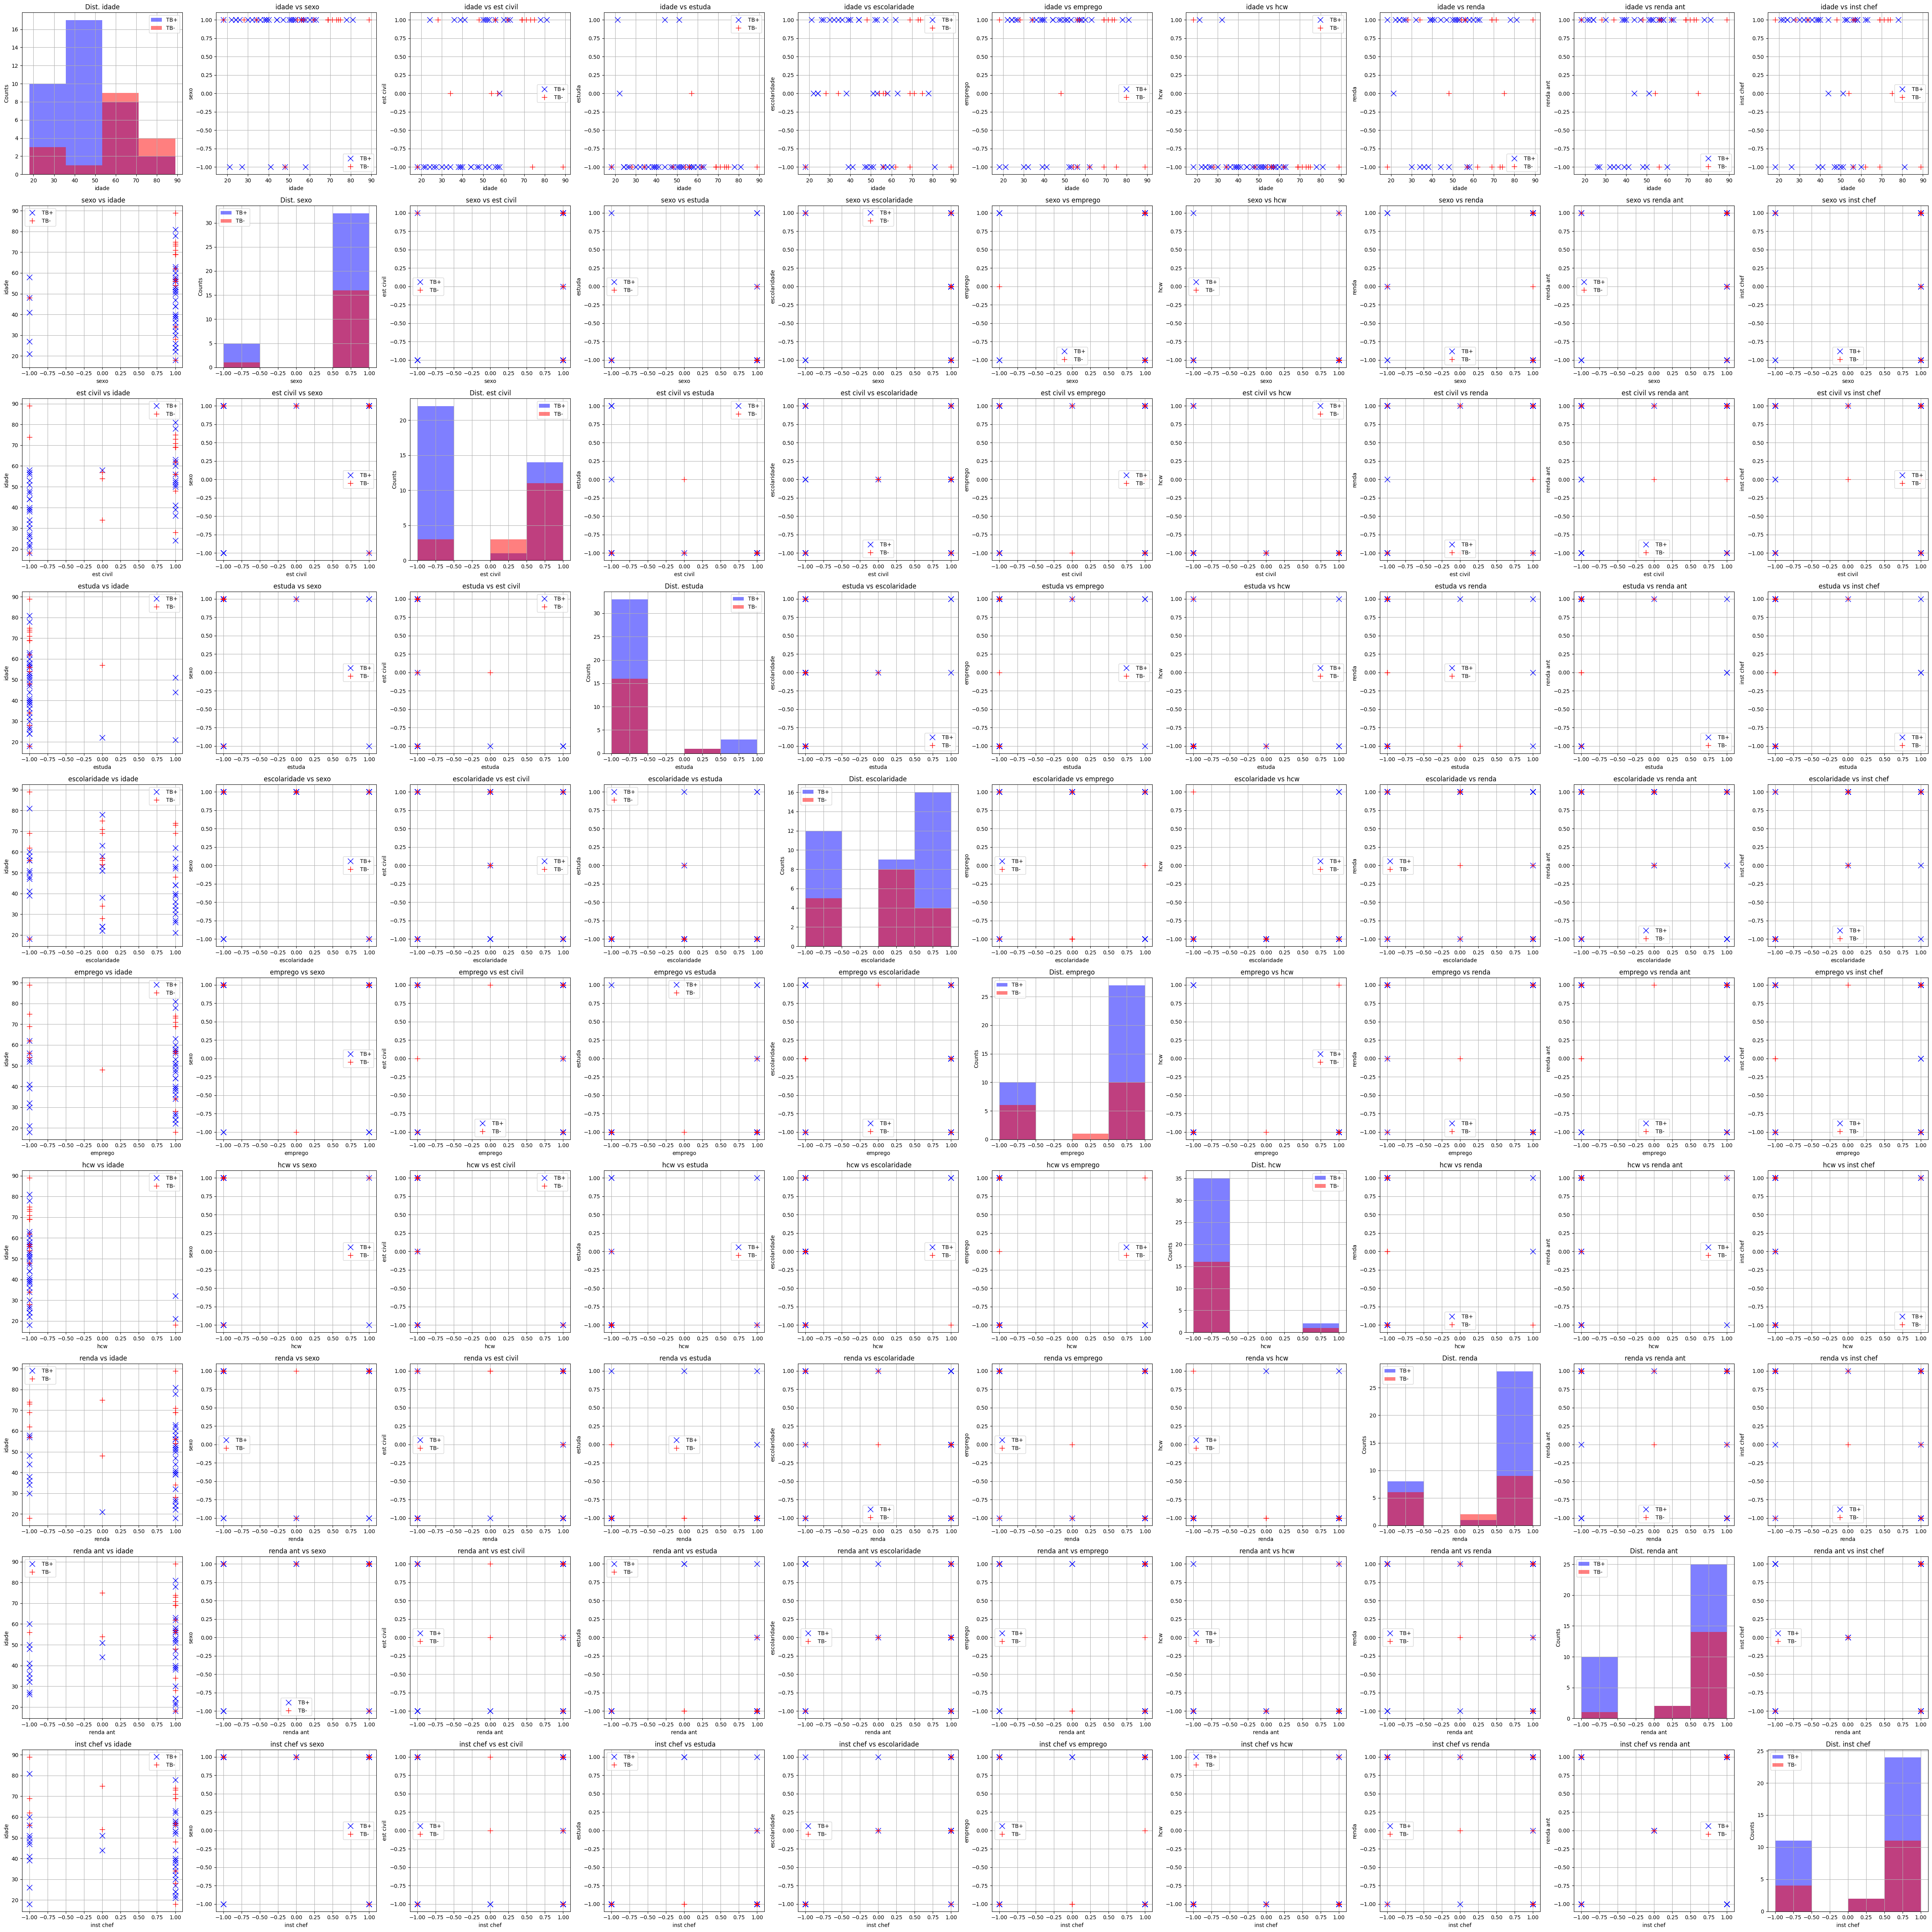

In [118]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_personal
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(50, 50))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_personal.pdf',bbox_inches='tight')
fig.savefig('scatter_personal.png',bbox_inches='tight', dpi=400)
plt.show()

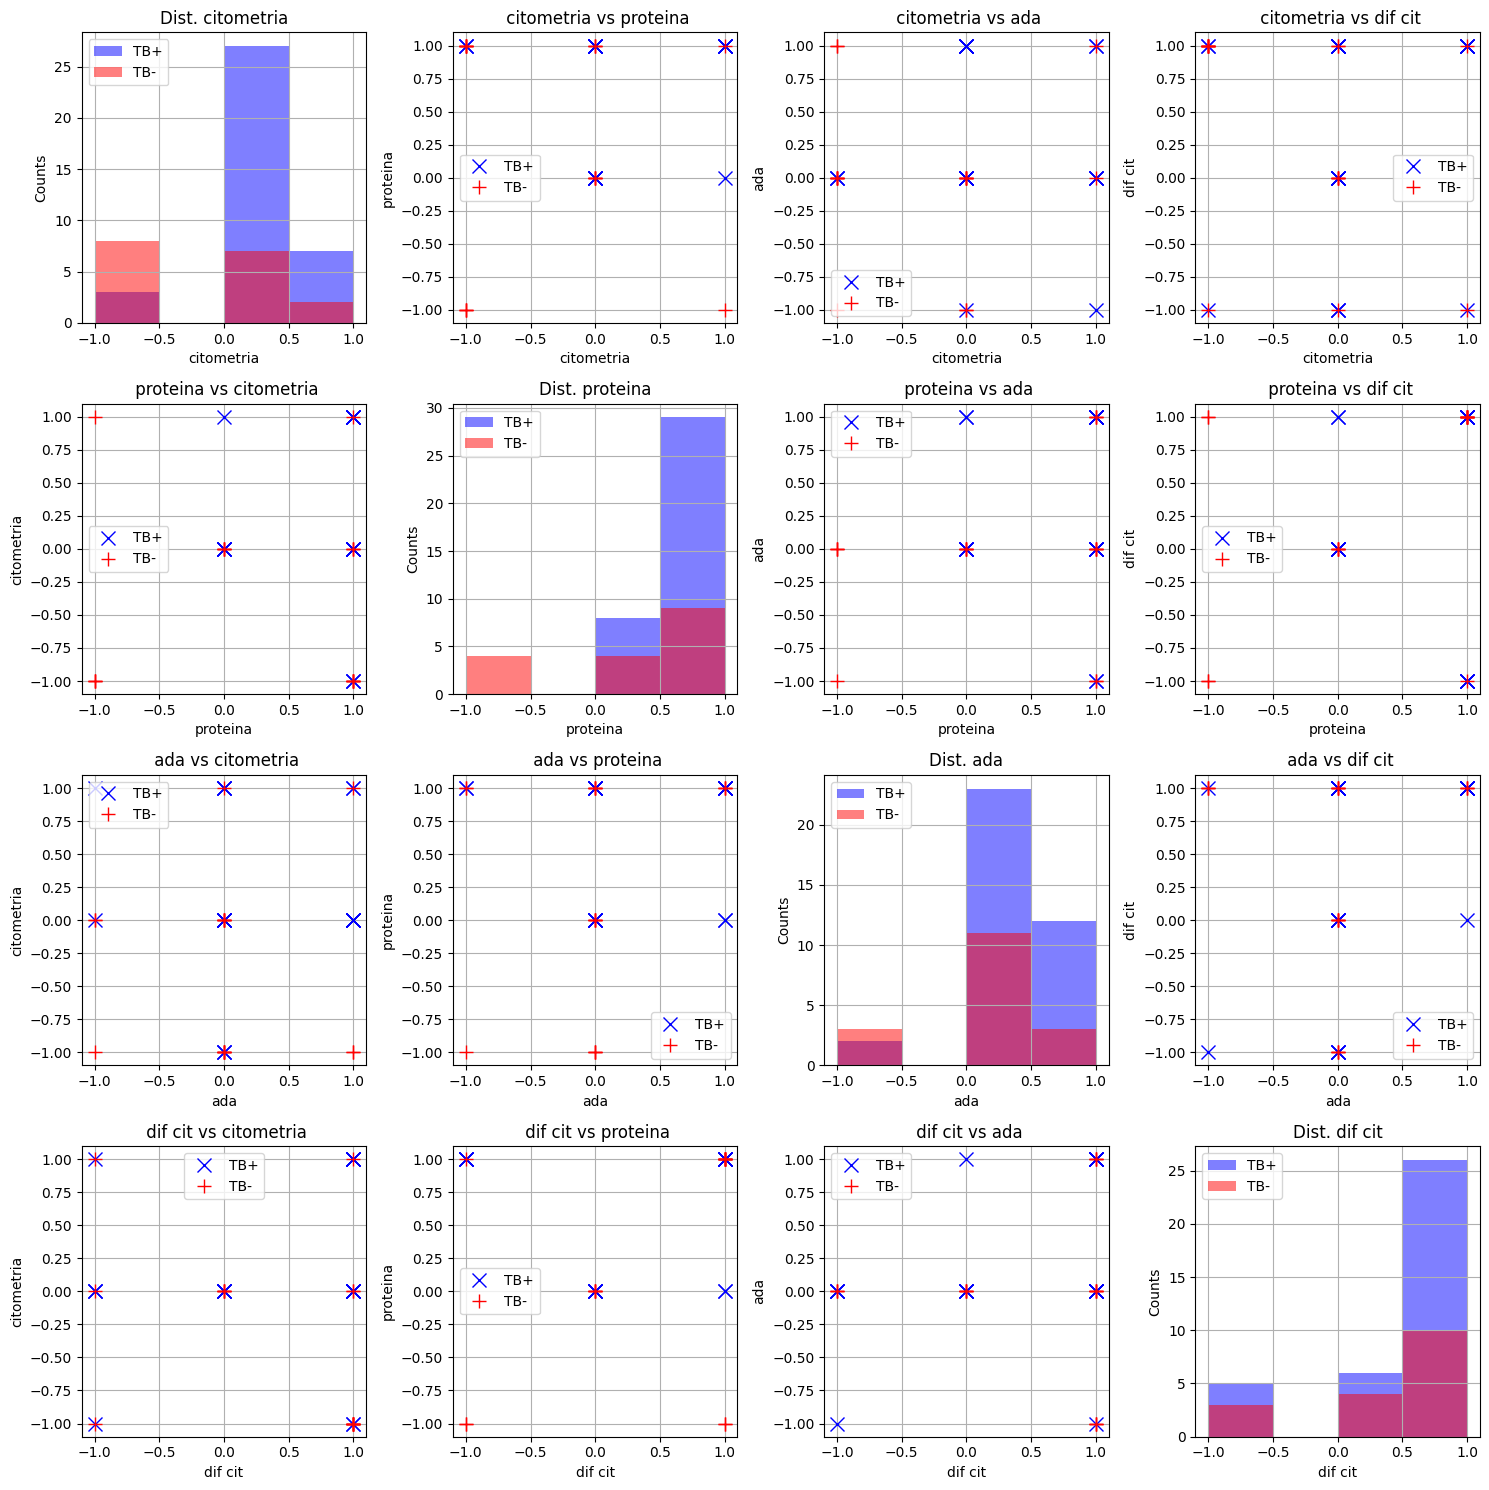

In [122]:
#anal_data = dev_social[['mo rua','preso']].copy(deep=True)
anal_data = dev_pos_test
qtd_variables = len(anal_data.columns)

#fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(6, 6))
fig, ax = plt.subplots(qtd_variables, qtd_variables,figsize=(15, 15))


for iid, ivar in enumerate(anal_data.columns):
    for jid, jvar in enumerate(anal_data.columns):
        #print ('ivar: %s, jvar: %s'%(ivar, jvar))
        if ivar == jvar:
            # print a distribution
            m_bins = np.linspace(np.min(anal_data[ivar].values),np.max(anal_data[ivar].values),5)
            #print('m_bins: ', m_bins)
            pos_values = anal_data[ivar].values
            pos_values = pos_values[:,np.newaxis]
            pos_values = pos_values[dev_target.values==1]
            
            neg_values = anal_data[ivar].values
            neg_values = neg_values[:,np.newaxis]
            neg_values = neg_values[dev_target.values==-1]
            
            ax[iid, jid].hist(pos_values, m_bins, facecolor='blue', alpha=0.5, label='TB+')
            ax[iid, jid].hist(neg_values, m_bins, facecolor='red', alpha=0.5, label='TB-')
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title('Dist. %s'%(ivar))
            ax[iid, jid].set_ylabel('Counts')
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
        else:
            # print a scatter plot
            pos_values_1 = anal_data[ivar].values
            pos_values_1 = pos_values_1[:,np.newaxis]
            pos_values_1 = pos_values_1[dev_target.values==1]
            
            neg_values_1 = anal_data[ivar].values
            neg_values_1 = neg_values_1[:,np.newaxis]
            neg_values_1 = neg_values_1[dev_target.values==-1]
            
            pos_values_2 = anal_data[jvar].values
            pos_values_2 = pos_values_2[:,np.newaxis]
            pos_values_2 = pos_values_2[dev_target.values==1]
            
            neg_values_2 = anal_data[jvar].values
            neg_values_2 = neg_values_2[:,np.newaxis]
            neg_values_2 = neg_values_2[dev_target.values==-1]
            
            ax[iid, jid].plot(pos_values_1, pos_values_2,'x', color='blue',label='TB+', markersize=10.)
            ax[iid, jid].plot(neg_values_1, neg_values_2,'+', color='red',label='TB-', markersize=10.)
            ax[iid, jid].legend(loc='best')
            ax[iid, jid].set_title(' %s vs %s'%(ivar,jvar))
            ax[iid, jid].set_ylabel(jvar)
            ax[iid, jid].set_xlabel(ivar)
            ax[iid, jid].grid()
plt.tight_layout()
fig.savefig('scatter_pos_test.pdf',bbox_inches='tight')
fig.savefig('scatter_pos_test.png',bbox_inches='tight', dpi=400)
plt.show()